In [ ]:
#all_slow

# Quick Walkthrough
> A quick end to end walk through - of running a small dataset through the various steps.

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Basics

First we import basics
- This creates a `settings.yaml` file from a template in a new directory (`~/.lemonpie`) 
- Then it loads global variables needed for everything like ..
    - `DEVICE` set to GPU if it exists, else CPU
    - Default paths for data(`DATA_STORE`), logs(`LOG_STORE`), models(`MODEL_STORE`) & experiments(`EXPERIMENT_STORE`)
    - And some other variables used in pre-processing

We also import `fastai.imports` for all other required external libs

In [ ]:
from lemonpie.basics import *
from fastai.imports import *

In [ ]:
DEVICE

device(type='cuda')

## Setup dataset

In [ ]:
DATA_STORE

'/home/vinod/.lemonpie/datasets'

Next we will download Synthea's 1,000 patients csv dataset into our datastore. 
- For more details about the smalll dataset we are downloading, [read the details on the Synthea website](https://synthea.mitre.org/downloads). 
- The resulting directory structure must be `{DATA_STORE}/synthea/1K/raw_original` 
- We already have a global variable called `PATH_1K` for convenience

In [ ]:
PATH_1K # global variable

'/home/vinod/.lemonpie/datasets/synthea/1K'

So, we create the directory structure for `PATH_1K` in our `DATA_STORE`

In [ ]:
Path.mkdir(Path(PATH_1K), parents=True, exist_ok=True)

Next, we download the data

In [ ]:
synthea_url = 'https://storage.googleapis.com/synthea-public/synthea_sample_data_csv_apr2020.zip'

import requests
data = requests.get(synthea_url)
data_file = Path(f'{PATH_1K}/data.zip')

if not data_file.exists():
    print(f'Downloading from {synthea_url}')
    with open(f'{PATH_1K}/data.zip', 'wb') as f:
        f.write(data.content)
else:
    print('File exists so skipping download')
print('Done!')

Done!


And unzip

In [ ]:
from zipfile import ZipFile
with ZipFile(f'{PATH_1K}/data.zip', 'r') as zipObj:
    zipObj.extractall(PATH_1K)

Synthea zip creates a `csv` directory, the library requires it to be named `raw_original`, so just renaming ..

In [ ]:
os.listdir(PATH_1K)

['csv', 'data.zip']

In [ ]:
os.rename(f'{PATH_1K}/csv', f'{PATH_1K}/raw_original')

In [ ]:
os.listdir(PATH_1K)

['data.zip', 'raw_original']

In [ ]:
os.listdir(f'{PATH_1K}/raw_original')

['patients.csv',
 'observations.csv',
 'allergies.csv',
 'payers.csv',
 'careplans.csv',
 'medications.csv',
 'devices.csv',
 'organizations.csv',
 'imaging_studies.csv',
 'procedures.csv',
 'payer_transitions.csv',
 'supplies.csv',
 'conditions.csv',
 'providers.csv',
 'encounters.csv',
 'immunizations.csv']

## Run pre-processing

- Before we pre-process the dataset, we need to decide which conditions will be populated in the pre-processed patients.
- Then when we train the models, the labels we train them on, will be a subset (or full set) of these pre-processed conditions.
- An initial set of conditions are provided in the `CONDITIONS` dictionary that was created when we imported basics and created an initial settings file above.

In [ ]:
CONDITIONS

{'diabetes': '44054006',
 'stroke': '230690007',
 'alzheimers': '26929004',
 'coronary_heart': '53741008',
 'lung_cancer': '254637007',
 'breast_cancer': '254837009',
 'rheumatoid_arthritis': '69896004',
 'epilepsy': '84757009'}

Next run preprocessing

In [ ]:
from lemonpie.preprocessing.transform import *

To get 20 years of data from Jan 1st 1995 for each patient, run as shown below.
- `age_start` - can be given an age in years or months - for example `5` years or `120` months (10 years)
- `age_range` - is the arg to specify how many years of months of data to get from the start
- `start_is_date` - is a boolean flag to specify if the start is a date (string in yyyy-mm-dd format) or and age (integer)
- `age_in_months` - is a boolean flag to specify if the aggreation of data must be by month or year
    - If `True` - data is aggregated per month of the patients life starting from the `age_start`
    - If `False` - data is aggregated per year of patient's life 
- `from_raw_data=True` - starts from scratch - cleans the data before generating objects in the given date range

In [ ]:
# 20 years from Jan 01 1995

preprocess_ehr_dataset(
    PATH_1K, 
    SYNTHEA_DATAGEN_DATES['1K'], 
    CONDITIONS, 
    age_start='1995-01-01',
    age_range=20,
    start_is_date=True,
    age_in_months=False,
    from_raw_data=True)

------------------- Splitting and cleaning raw dataset -------------------
Splits:: train: 0.6, valid: 0.2, test: 0.2
Split patients into:: Train: 702, Valid: 234, Test: 235 -- Total before split: 1171
Saved train data to /home/vinod/.lemonpie/datasets/synthea/1K/raw_split/train
Saved valid data to /home/vinod/.lemonpie/datasets/synthea/1K/raw_split/valid
Saved test data to /home/vinod/.lemonpie/datasets/synthea/1K/raw_split/test


2022-09-22 13:04:31,659	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8266


Completed - test
(pid=17165) Saved cleaned "test" data to /home/vinod/.lemonpie/datasets/synthea/1K/cleaned/test
Completed - valid
(pid=17055) Saved cleaned "valid" data to /home/vinod/.lemonpie/datasets/synthea/1K/cleaned/valid
(pid=17083) Saved cleaned "train" data to /home/vinod/.lemonpie/datasets/synthea/1K/cleaned/train
Completed - train
------------------- Creating vocab lists -------------------
(pid=17083) Saved vocab code tables to /home/vinod/.lemonpie/datasets/synthea/1K/cleaned/train/codes
Saved vocab lists to /home/vinod/.lemonpie/datasets/synthea/1K/processed
------------------- Creating patient lists -------------------
702 total patients completed, saved patient list to /home/vinod/.lemonpie/datasets/synthea/1K/processed/years_1995-01-01_plus_20/train
234 total patients completed, saved patient list to /home/vinod/.lemonpie/datasets/synthea/1K/processed/years_1995-01-01_plus_20/valid
235 total patients completed, saved patient list to /home/vinod/.lemonpie/datasets/synt

## Run models
Assemble everything needed for training and run the models

- Before we run the models, we need to decide which labels we want to train the models on.
- And these labels must be a subset of the conditions we used when pre-processing the dataset (as mentioned above). 
- Say we pick the following subset

In [ ]:
labels = ['diabetes', 'stroke', 'alzheimers', 'coronary_heart', 'breast_cancer', 'epilepsy']

Next, create the data object
- This provides data management tools like data loaders etc.

In [ ]:
from lemonpie import data

In [ ]:
ehr_1K_data = data.EHRData(
    PATH_1K, 
    labels,     
    age_start='1995-01-01',
    age_range=20,
    start_is_date=True,
    age_in_months=False,)

Load vocabs and their dimensions
- These were created in the pre-processing step above

In [ ]:
from lemonpie.preprocessing import vocab

In [ ]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = vocab.get_all_emb_dims(vocab.EhrVocabList.load(PATH_1K))

Get DataLoaders

In [ ]:
train_dl, valid_dl, train_pos_wts, valid_pos_wts = ehr_1K_data.get_data()

Loss functions

In [ ]:
from lemonpie import learn

In [ ]:
train_loss_fn, valid_loss_fn = learn.get_loss_fn(train_pos_wts), learn.get_loss_fn(valid_pos_wts)

### LSTM

In [ ]:
from lemonpie import models

In [ ]:
model = models.EHR_LSTM(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd, len(labels)).to(DEVICE)

Optimizer

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters())

Then run fit

In [ ]:
h = learn.RunHistory(labels)

In [ ]:
from lemonpie import metrics

In [ ]:
h = learn.fit(
    epochs=5, 
    history=h, 
    model=model, 
    train_loss_fn=train_loss_fn, 
    valid_loss_fn=valid_loss_fn, 
    optimizer=optimizer, 
    accuracy_fn=metrics.auroc_score,
    train_dl=train_dl, 
    valid_dl=valid_dl, 
    to_chkpt_path=MODEL_STORE, 
    from_chkpt_path=None, 
    verbosity=1)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |         22.234 | [0.450 0.438 0.493 0.465]              1.221 | [0.665 0.725 0.985 0.814]
    1 |          1.254 | [0.679 0.833 0.841 0.677]              1.091 | [0.665 0.722 0.991 0.821]
    2 |          1.189 | [0.686 0.817 0.878 0.721]              1.036 | [0.702 0.713 0.989 0.843]
    3 |          1.081 | [0.777 0.894 0.897 0.785]              1.088 | [0.683 0.702 0.986 0.835]
    4 |          0.866 | [0.806 0.888 0.939 0.777]              1.157 | [0.694 0.704 0.987 0.716]
Checkpointed to "/home/vinod/.lemonpie/models/checkpoint.tar"


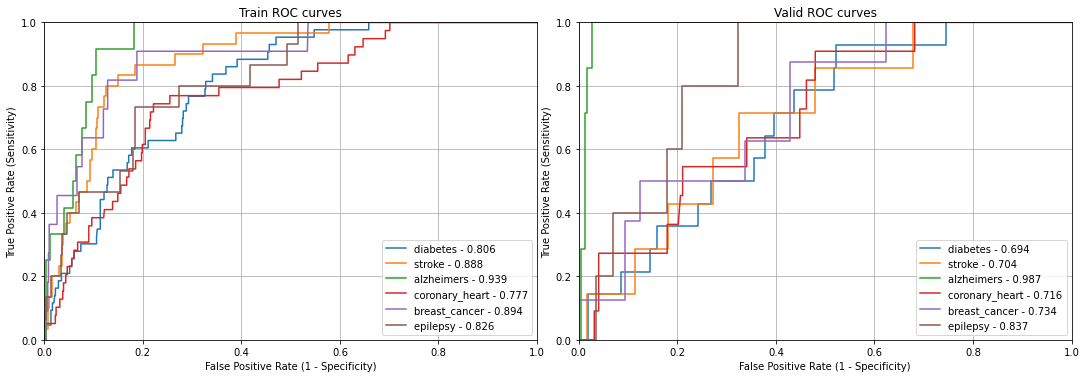

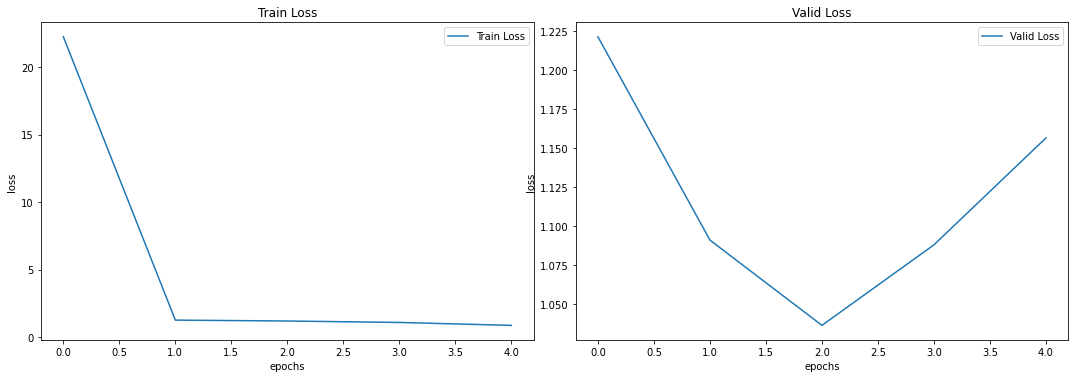

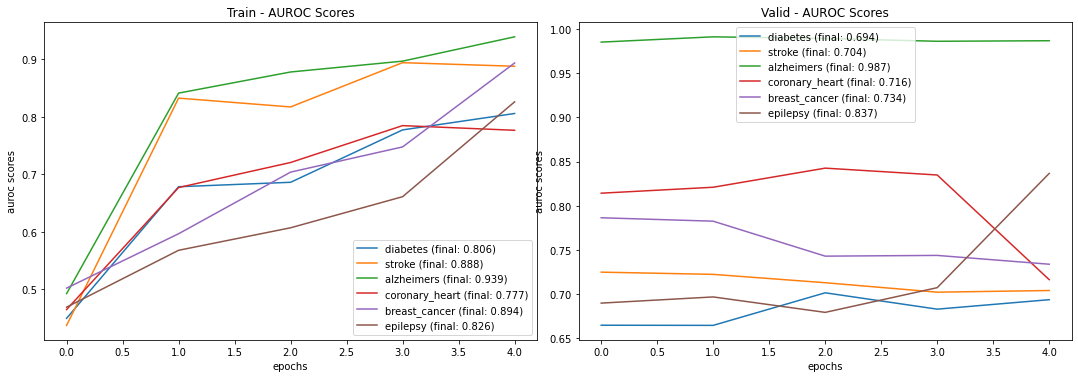

In [ ]:
learn.plot_fit_results(h, labels)

Run inference on the test set

In [ ]:
test_dl, test_pos_wts = ehr_1K_data.get_test_data()

In [ ]:
test_loss_fn = learn.get_loss_fn(test_pos_wts)

In [ ]:
h = learn.predict(h, model, test_loss_fn, metrics.auroc_score, test_dl, chkpt_path=MODEL_STORE)

From "/home/vinod/.lemonpie/models/checkpoint.tar", loading model ...
test loss = 1.3388717770576477
test aurocs = [0.72941  0.921672 0.882824 0.662135 0.991416 0.45279 ]



Prediction Summary ...
                auroc_score  optimal_threshold     auroc_95_ci
diabetes           0.729410           0.229614  (0.631, 0.815)
stroke             0.921672           1.536133  (0.851, 0.975)
alzheimers         0.882824           0.638672  (0.797, 0.957)
coronary_heart     0.662135           1.592773  (0.462, 0.833)
breast_cancer      0.991416           1.000977    (0.978, 1.0)
epilepsy           0.452790          -0.271484   (0.12, 0.794)


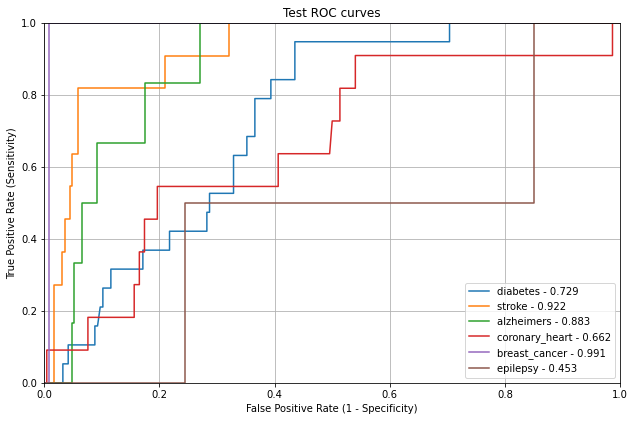

In [ ]:
h = learn.summarize_prediction(h, labels)

In [ ]:
h.prediction_summary

,auroc_score,optimal_threshold,auroc_95_ci
diabetes,0.729410,0.229614,"(0.631, 0.815)"
stroke,0.921672,1.536133,"(0.851, 0.975)"
alzheimers,0.882824,0.638672,"(0.797, 0.957)"
coronary_heart,0.662135,1.592773,"(0.462, 0.833)"
breast_cancer,0.991416,1.000977,"(0.978, 1.0)"
epilepsy,0.452790,-0.271484,"(0.12, 0.794)"


> Important: Make sure to only use labels that have atleast 1 "True" value in each split. That is, "y_true" contains both false and at least one true.
Else AUROC score calculation is not possible resulting in this error **ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.**

The way to find out is to get prevalence counts after creating the data object. See following example which uses the data object we created above.

In [ ]:
ehr_1K_data.load_splits()

In [ ]:
ehr_1K_data.splits.get_label_counts(list(CONDITIONS.keys()))

,train,valid,test,total
diabetes,43,14,19,76
stroke,30,7,11,48
alzheimers,12,7,6,25
coronary_heart,39,11,11,61
lung_cancer,12,0,2,14
breast_cancer,11,8,2,21
rheumatoid_arthritis,2,0,0,2
epilepsy,15,5,2,22


In this small 1K dataset, 'lung_cancer' and 'rheumatoid_arthritis' have single classes in some splits (e.g. no lung_cancer patients in validation set) as seen in the prevalence counts above and would result in the above failure when fit is run.

**However, in large datasets the possibility of this is very low, but its something to watch out for.**

### CNN

In [ ]:
model = models.EHR_CNN(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd, num_labels=len(labels)).to(DEVICE)

In [ ]:
h2 = learn.RunHistory(labels)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
h2 = learn.fit(
    5, 
    h, 
    model, 
    train_loss_fn, 
    valid_loss_fn, 
    optimizer, 
    metrics.auroc_score, 
    train_dl, 
    valid_dl, 
    to_chkpt_path=None, 
    from_chkpt_path=None, 
    verbosity=0.5)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |          4.921 | [0.565 0.482 0.631 0.615]              1.160 | [0.687 0.743 0.983 0.839]
    4 |          0.801 | [0.846 0.930 0.959 0.780]              1.160 | [0.694 0.702 0.977 0.824]
